In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Задание №1

В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

In [2]:
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

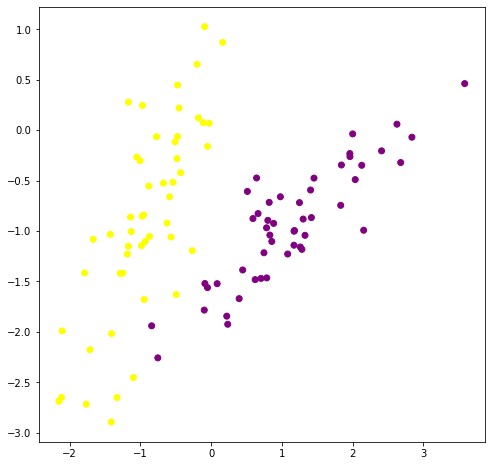

In [3]:
# Визуалищируем данные
colors = ListedColormap(['yellow', 'purple'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), c=classification_labels, cmap=colors)
plt.show()

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t # значение порога
        self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
    
    # подсчет количества объектов разных классов
    def predict(self):
        classes = {} # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0] / left_labels.shape[0] + right_labels.shape[0])
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3
    
    root_gini = gini(labels)
    
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
                
    return best_gain, best_t, best_index

In [10]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth):
    
    global leafs_quantity
    global max_leafs_quantity
    depth = 0
    
    gain, t, index = find_best_split(data, labels)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0 or depth > max_depth or leafs_quantity >= max_leafs_quantity:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    leafs_quantity += 1
    true_branch = build_tree(true_data, true_labels, depth+1)
    false_branch = build_tree(false_data, false_labels, depth+1)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):
    
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
leafs_quantity = 1
max_leafs_quantity = 25
my_tree = build_tree(train_data, train_labels, 0)

In [15]:
print(leafs_quantity)

23


In [16]:
# Напечатаем ход нашего дерева

def print_tree(node, spacing=""):
    
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + 'Прогноз:', node.prediction)
        return
    
    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= -1.7124426610298529
--> True:
  Прогноз: 0
--> False:
  Индекс 0 <= -1.4121643353903564
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0 <= -1.2499312777434102
    --> True:
      Прогноз: 0
    --> False:
      Индекс 1 <= -1.8446354603590789
      --> True:
        Прогноз: 1
      --> False:
        Индекс 0 <= -1.1696331250622611
        --> True:
          Прогноз: 0
        --> False:
          Индекс 0 <= -0.9715037016309751
          --> True:
            Прогноз: 0
          --> False:
            Индекс 0 <= -0.931427286340031
            --> True:
              Прогноз: 0
            --> False:
              Индекс 0 <= -0.674498539454033
              --> True:
                Прогноз: 0
              --> False:
                Индекс 0 <= -0.5403007857080191
                --> True:
                  Прогноз: 0
                --> False:
                  Индекс 0 <= -0.48221701522338245
                  --> True:
                    Прогноз: 0
          

In [17]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [18]:
# И получим ответы для тестовой выборки
test_answers = predict(test_data, my_tree)

In [19]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.14285714285714

In [21]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
test_accuracy

90.0

In [22]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

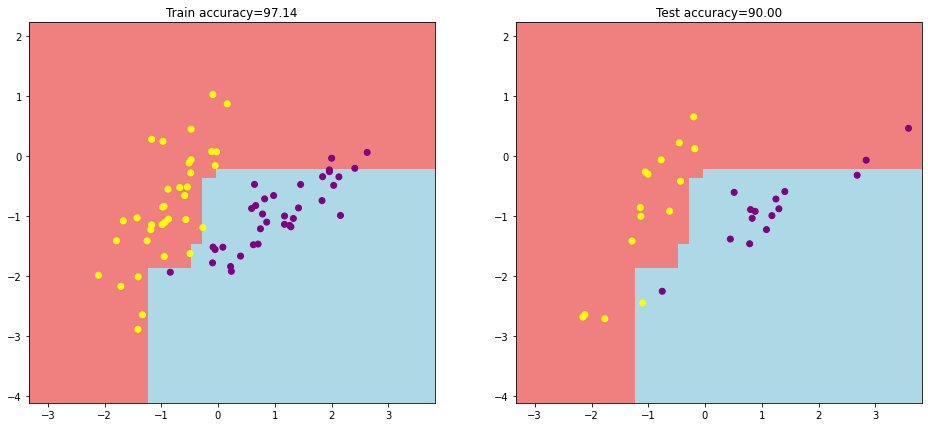

In [23]:
visualize(train_data, test_data)

# Задание №2

Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [24]:
regression_data, regression_target, coef = make_regression(n_samples=100, n_features=2, n_informative=1, n_targets=1, noise=5, coef=True, random_state=42)


In [25]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t # значение порога
        self.true_branch = true_branch # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch # поддерево, не удовлетворяющее условию в узле

In [26]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.prediction = self.predict()
    
    # подсчет количества объектов разных классов
    def predict(self):
        # найдем среднее значение в листе
        prediction = np.mean(self.target)
        return prediction

In [27]:
# Расчет дисперсии

def mse(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

In [28]:
# Расчет прироста

def gain(left_labels, right_labels, root_mse):
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0] / left_labels.shape[0] + right_labels.shape[0])
    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [29]:
# Разбиение датасета в узле

def split(data, target, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    true_data = data[left]
    false_data = data[right]
    
    true_target = target[left]
    false_target = target[right]
    
    return true_data, false_data, true_target, false_target

In [30]:
# Нахождение наилучшего разбиения

def find_best_split(data, target):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3
    
    root_mse = mse(target)
    
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_target, false_target = split(data, target, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            current_gain = gain(true_target, false_target, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
                
    return best_gain, best_t, best_index

In [31]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target, max_depth):
    
    global leafs_quantity
    global max_leafs_quantity
    depth = 0
    
    gain, t, index = find_best_split(data, target)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0 or depth > max_depth or leafs_quantity >= max_leafs_quantity:
        return Leaf(data, target)
    
    true_data, false_data, true_target, false_target = split(data, target, index, t)
    
    # Рекурсивно строим два поддерева
    leafs_quantity += 1
    true_branch = build_tree(true_data, true_target, depth+1)
    false_branch = build_tree(false_data, false_target, depth+1)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [32]:
def classify_object(obj, node):
    
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [33]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [34]:
# Разобьем выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(regression_data, 
                                                                    regression_target, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [35]:
# Построим дерево по обучающей выборке
leafs_quantity = 1
max_leafs_quantity = 15
my_tree = build_tree(train_data, train_target, 5)

In [36]:
# Напечатаем ход нашего дерева

def print_tree(node, spacing=""):
    
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + 'Прогноз:', node.prediction)
        return
    
    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= -1.4123037013352915
--> True:
  Прогноз: -43.116052109259456
--> False:
  Индекс 1 <= -0.6451197546051243
  --> True:
    Прогноз: 26.296127232156266
  --> False:
    Индекс 0 <= -1.4153707420504142
    --> True:
      Прогноз: -162.14030220761614
    --> False:
      Индекс 0 <= -1.0623037137261049
      --> True:
        Прогноз: -94.61832156949576
      --> False:
        Индекс 0 <= -0.9746816702273214
        --> True:
          Прогноз: -88.07769089018275
        --> False:
          Индекс 0 <= -0.7832532923362371
          --> True:
            Прогноз: -79.30324999931928
          --> False:
            Индекс 0 <= -0.6017066122293969
            --> True:
              Прогноз: -58.591846974127044
            --> False:
              Индекс 0 <= -0.4694743859349521
              --> True:
                Прогноз: -43.10333892293337
              --> False:
                Индекс 0 <= -0.4465149520670211
                --> True:
                  Прогноз: -39.0331

In [37]:
# Введем функцию подсчета квадрата детерминации

def r2_score(y, y_pred):
    result = 1 - (np.mean((y - y_pred)**2) / np.mean((y - np.mean(y))**2))
    return result

In [38]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [39]:
# И получим ответы для тестовой выборки
test_answers = predict(test_data, my_tree)

In [40]:
# Точность на обучающей выборке
train_r2 = r2_score(train_target, train_answers)
train_r2

0.755359819199073

In [41]:
# Точность на тестовой выборке
test_r2 = r2_score(test_target, test_answers)
test_r2

0.503543344701094

In [42]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train R2={train_r2:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test R2={test_r2:.2f}')

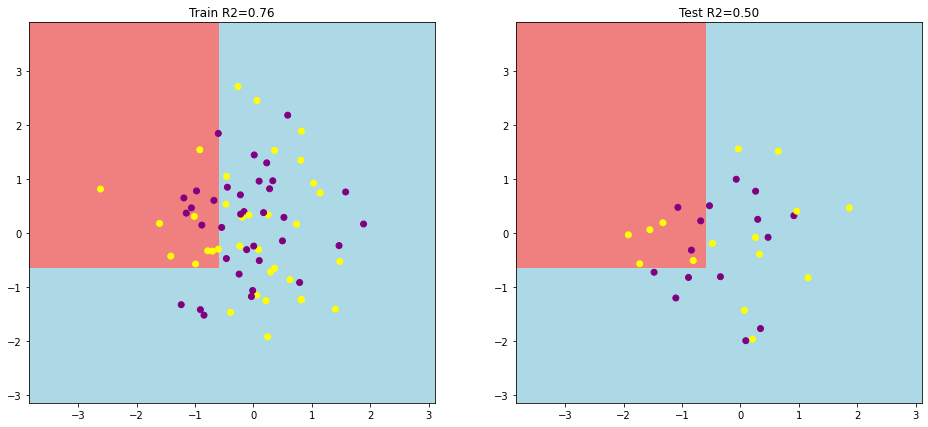

In [43]:
visualize(train_data, test_data)